In [3]:
import pandas as pd
import requests
import json
import scipy
%pylab inline
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


Someone Else is Buying your House of Representatives Race
====

The House of Representatives is intended to be the most democratic part of the Federal Government. The voter to representative ratio is the smallest of any federally elected office (excepting single-representative states). However, the relatively lower overall number of votes in each congressional district and the localized nature of most races means that money can play an outsized role. 

A candidate can saturate a single district by buying up airtime on local radio and tv stations for much less than the cost of saturation in a medium to large state Senate race or a national race like President. Money is hypothesized to be more efficient in House races. Where does that money come from?

It turns out, the money in House Races is highly concentrated both in terms of where it comes from and where it's spent. 

In this post, I use the FEC election contributions to show that donations to House candidates are decidedly undemocratic: 76.6% of all registered donations (>$200 per person per cycle) are donated to candidates from individuals that live outside of the district receiving the money. Only 62 of 435 Districts (14%) are responsible for *half* of all donations to House candidates. Competitive House races in 2012 are the main beneficiaries of this largess, and safe, urban, blue districts are the primary contributors. 

Basic data
-----------

If you want to run this notebook, start with the Getting The Data section, which extracts the base data and produces a few summaries:

    df = Amount of money given from every district to every district
    df_recipient_districts = Aggregation of amount of money received from within a district and from outside the district.
    df_donor_districts = Aggregation of amount of money donated by a district to candidates within the district vs candidates outside the district.



Most of the Money in House Races isn't Local
--------------------------------------------

In a result that surprised no one, most contributions to House Races are not contributed by people who actually live in the district. In fact, only 23% of money from itemized donations (>$200) gets contributed to House candidates that the recipient could vote for!

In [18]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_recipient_districts[["DonateFromOther", "DonateFromSelf"]].sum()

DonateFromOther   224487833.000
DonateFromSelf     68472408.780
dtype: float64

In [19]:
tmp = df_recipient_districts[["DonateFromOther", "DonateFromSelf"]].sum()
print("Amount of money from within district: {0}".format(tmp[1] / tmp.sum() * 100))

Amount of money from within district: 23.3725943029


For most of us, the ratio is even worse: the average district receives 82% of registered donations from outside of the district. 

count    440.000000
mean       0.211675
std        0.144692
min        0.000000
25%        0.106943
50%        0.180301
75%        0.293276
max        0.898043
Name: DonateFromSelfRatio, dtype: float64

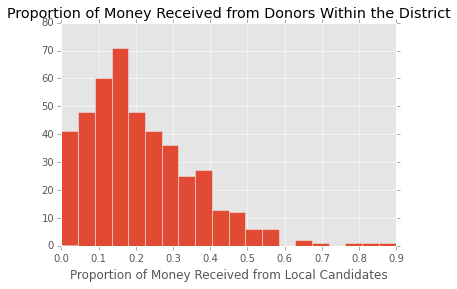

In [22]:
# calculate breakdown
df_recipient_districts.DonateFromSelfRatio.hist(bins=20)
plt.title("Proportion of Money Received from Donors Within the District")
plt.xlabel("Proportion of Money Received from Local Candidates")
df_recipient_districts.DonateFromSelfRatio.describe()

Someone else is buying our House of Representatives races. Who is it?

Where does the money come from?
----------------------------------

In terms of raw money donated, the top donor districts are rich, urban, and often near D.C. MD-8, VA-8 and VA-11 are the Districts closest to Washington D.C.: they are full of lobbyists and other government types. MA-7 forms a ring around Boston and includes a lot of rich and politically active areas. NY-10 and NY-12 are on Manhattan. CA-33 (LA), IL-7 (Chicago) and FL-22 (Miami) represent the nicer parts of several large cities.

In [21]:
df_donor_districts.sort_values("DonateToOther", ascending=False).head(10)

,SourceState,SourceDistrict,DonateToOther,DonateToSelf,DonateToSelfRatio
408,VA,8,15741659,157863.620,0.010
185,MA,7,8427341,7096.110,0.001
282,NY,12,6480177,216676.020,0.032
411,VA,11,5480489,72030.940,0.013
280,NY,10,3560187,180160.810,0.048
410,VA,10,3444826,616084.000,0.152
108,FL,22,3043944,127764.750,0.040
53,CA,33,3009517,178201.970,0.056
142,IL,7,2935345,37020.000,0.012
195,MD,8,2840440,841024.330,0.228


Outside donations as a response to safe seats
-------------------------------------------------

This section examines the flow of money from safe seats to highly contested seats. After some data gathering and cleaning, we show that safe seats predominantly donate their money to House races that are closer to draw. Most money actually comes *from* safe districts (and Democratic ones at that) but that money goes *to* the districts whose 2012 vote was closest. Specifically: 

1) Districts that see large outflows of money tend to be safer seats (margin of victory was large), while

2) Districts that see large inflows of money tend to be competitive.

If you just want to see the result, scroll down to the next image. If you are interested in the details, read on.

We use the 2012 election results as a proxy for competitiveness. Time Magazine has a set of raw elections results on Github that we use as a base. The FEC also provides this data, but Time was nice enough to clean it up a bit. Third party candidates get lumped together and candidates with more than one party get assigned one of the majors. Note that many races were unopposed. In this data, I give them 1 vote to 0 for the "opponent" so the ratio of votes (calculated below) is all that really matters.

In [11]:
def clean_party(party):
    ret_val = ""
    party = party.lower()
    if "democrat" in party:
        ret_val += "Dem"
    elif "republican" in party:
        ret_val += "Rep"
    ret_val = "Other" if not ret_val else ret_val
    return ret_val

# Get data from Time Magazine (thanks!)
df_previous_results = pd.read_csv("https://raw.githubusercontent.com/TimeMagazine/congressional-election-results/master/data/results_2012.csv")
# Clean up various fields and remove non-standard candidates for simplicity.
df_previous_results['clean_party'] = df_previous_results.parties.apply(clean_party)
df_previous_results['clean_votes'] = df_previous_results.votes.apply(lambda x: 1 if x == "Unopposed" else int(x))  # NOTE: we only use ratios in final analysis.
df_previous_results_clean = df_previous_results[df_previous_results['clean_party'] != '']
df_previous_results_clean = df_previous_results_clean[df_previous_results_clean.district != "S"]
df_previous_results_clean['clean_district'] = df_previous_results_clean.district.apply(lambda x: int(x.split(' ')[0]))

# pivot
df_previous_results_p = df_previous_results_clean.pivot_table(index=["state", "clean_district"], columns="clean_party", values="clean_votes", fill_value=0).reset_index()
#df_previous_results_p.loc[df_previous_results_p.clean_district == 0, 'clean_district'] = 1
df_previous_results_p["RepublicanRatio"] = df_previous_results_p.Rep / (df_previous_results_p.Dem + df_previous_results_p.Rep + df_previous_results_p.Other)
# DifferenceFromEven represents the difference from a 50/50 election.
df_previous_results_p["DifferenceFromEven"] = abs(0.5 - df_previous_results_p.RepublicanRatio)

One more bit of data cleaning: I create `df_donor_with_previoushist` to calculate total donations to candidates within and outside a district grouped by the competitiveness of the race.

In [12]:
df_donor_with_previous = df_donor_districts.merge(df_previous_results_p, left_on=["SourceState", "SourceDistrict"], right_on=["state", "clean_district"], how='inner')
df_donor_with_previous = df_donor_with_previous.sort_values("RepublicanRatio")

df_donor_with_previous["RatioDiscrete"] = df_donor_with_previous.RepublicanRatio.apply(lambda x: int(x * 9.99999) / 10.)
df_donor_with_previous["TotalContributions"] = df_donor_with_previous.DonateToOther + df_donor_with_previous.DonateToSelf
df_donor_with_previoushist = df_donor_with_previous.groupby("RatioDiscrete").agg({"DonateToOther": sum, "DonateToSelf": sum}).reset_index()

**The plots**

If you skipped all that data munging, welcome back. It's time to make some plots. I'm not a matplotlib expert so apologies if I offended anyone with this next chunk of code. See below the plots for a discussion.

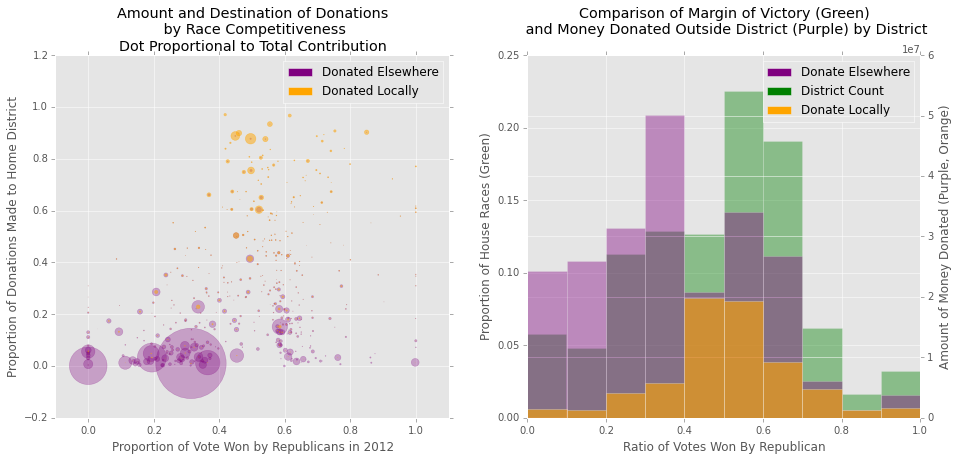

In [45]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15.5, 6.5)
plt_0_0 = axs[0].scatter(
    df_donor_with_previous.RepublicanRatio, 
    df_donor_with_previous.DonateToSelfRatio, 
    s=(df_donor_with_previous.DonateToOther) ** 2 / (50000000000),
    alpha=0.3,
    color='purple'
)
_ = axs[0].set_xlim(-0.1, 1.1)
_ = axs[0].set_title("Amount and Destination of Donations \n by Race Competitiveness\nDot Proportional to Total Contribution")
_ = axs[0].set_xlabel("Proportion of Vote Won by Republicans in 2012")
_ = axs[0].set_ylabel("Proportion of Donations Made to Home District")

plt_0_1 = axs[0].scatter(
    df_donor_with_previous.RepublicanRatio, 
    df_donor_with_previous.DonateToSelfRatio, 
    s=(df_donor_with_previous.DonateToSelf) ** 2 / (50000000000),
    alpha=.5,
    color='orange'
)

import matplotlib.patches as mpatches
recs = [mpatches.Rectangle((0,0),1,1,fc='purple'), mpatches.Rectangle((0,0),1,1,fc='orange')]
axs[0].legend(recs, ('Donated Elsewhere', 'Donated Locally'))

axs[1].hist(df_donor_with_previous.RepublicanRatio * 10, normed=True, alpha=0.4, color='green')
axs2 = axs[1].twinx()
axs2.bar(np.arange(10), df_donor_with_previoushist.DonateToOther, 1, alpha=.4, color='purple')
axs2.bar(np.arange(10), df_donor_with_previoushist.DonateToSelf, 1, alpha=.6, color="orange")
_ = axs[1].set_title('Comparison of Margin of Victory (Green)\n and Money Donated Outside District (Purple) by District\n')
_ = axs[1].set_ylabel("Proportion of House Races (Green)")
_ = axs2.set_ylabel("Amount of Money Donated (Purple, Orange)")
_ = axs[1].set_xlabel("Ratio of Votes Won By Republican")
_ = axs[1].set_xticklabels([.2 * i for i in range(10)])

recs = [mpatches.Rectangle((0,0),1,1,fc='purple'), mpatches.Rectangle((0,0),1,1,fc='green'), mpatches.Rectangle((0,0),1,1,fc='orange')]
_ = axs[1].legend(recs, ('Donate Elsewhere', 'District Count', 'Donate Locally'))

The left plot compares the competitiveness of a district in 2012 (x-axis) to the ratio of money donated to self in that district. Each district is actually over-plotted in purple and orange. The purple dot's size is proportional to the amount of money donated outside the district while the orange dot's size is proportional to the amount of money donated within district. 

On the right, I "collapse" the plot along the x-axis to show the aggregate money by district result. The green histogram shows the relative competitiveness of each district: the peak around 55-65% Republican corresponds to the blowout win by the GOP in 2012. They have the largest majority any party has enjoyed in decades. The blue histogram shows the money donated to candidates outside of the donor's district. Note that it skews heavily towards more Democratic districts (peak of around 35% Republican vote) and that, in general, donations to outside districts come from non-competitive races. Finally, the orange histogram shows that competitive races tend to draw the most money from within the district. If you live in a competitive district, your candidate will be more focused on raising money and will naturally be hitting up his or her own constituency.

We quantify the relationship between competitiveness and proportion of money donated within-district using Pearson Correlation. As races become less competitive (DifferenceFromEven goes UP), the ratio of money donated to the district vs outside the district goes DOWN.

In [270]:
df_recipient_with_previous[["DonateFromSelfRatio", "DifferenceFromEven"]].corr("pearson")

,DonateFromSelfRatio,DifferenceFromEven
DonateFromSelfRatio,1.000000,-0.210375
DifferenceFromEven,-0.210375,1.000000


**What is the impact on money spent for competitive races?**

The code for the plots is below. See the output after that.

In [24]:
df_recipient_with_previous = df_recipient_districts.merge(df_previous_results_p, left_on=["RecipientState", "RecipientDistrict"], right_on=["state", "clean_district"], how='inner')
df_recipient_with_previous = df_recipient_with_previous.sort_values("RepublicanRatio")

df_recipient_with_previous["RatioDiscrete"] = df_recipient_with_previous.RepublicanRatio.apply(lambda x: int(x * 9.999999) / 10.)
df_recipient_with_previous["TotalContributions"] = df_recipient_with_previous.DonateFromOther + df_recipient_with_previous.DonateFromSelf
df_recipient_with_previoushist = df_recipient_with_previous.groupby("RatioDiscrete").agg({"DonateFromOther": sum, "DonateFromSelf": sum}).reset_index()

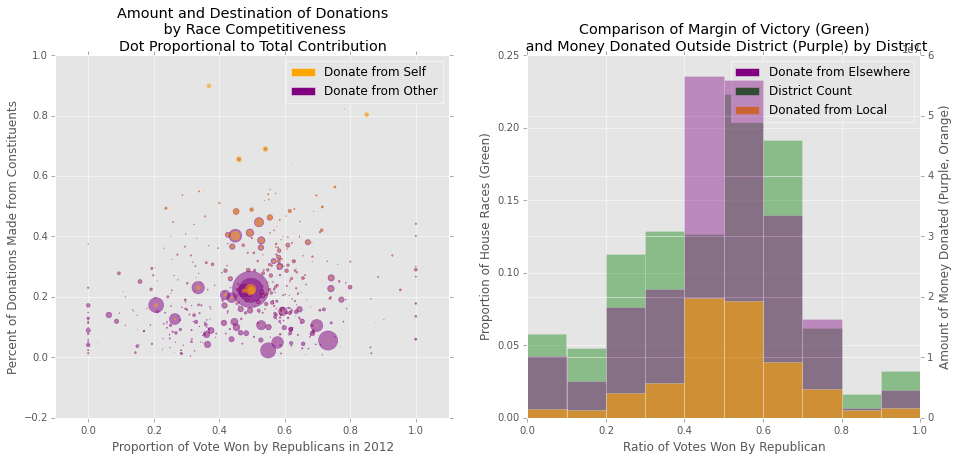

In [46]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15.5, 6.5)

axs[0].scatter(
    df_recipient_with_previous.RepublicanRatio, 
    df_recipient_with_previous.DonateFromSelfRatio, 
    s=(df_recipient_with_previous.DonateFromOther) ** 2 / (50000000000),
    alpha=.5,
    color='purple'
)

axs[0].scatter(
    df_recipient_with_previous.RepublicanRatio, 
    df_recipient_with_previous.DonateFromSelfRatio, 
    s=(df_recipient_with_previous.DonateFromSelf) ** 2 / (50000000000),
    alpha=.5,
    color="orange"
)
_ = axs[0].set_xlim(-0.1, 1.1)
_ = axs[0].set_title("Amount and Destination of Donations \n by Race Competitiveness\nDot Proportional to Total Contribution")
_ = axs[0].set_xlabel("Proportion of Vote Won by Republicans in 2012")
_ = axs[0].set_ylabel("Percent of Donations Made from Constituents")



recs = [mpatches.Rectangle((0,0),1,1,fc='orange'), mpatches.Rectangle((0,0),1,1,fc='purple')]
axs[0].legend(recs, ('Donate from Self', 'Donate from Other'))

axs[1].hist(df_recipient_with_previous.RepublicanRatio * 10, normed=True, alpha=0.4, color='green')
axs2 = axs[1].twinx()
axs2.bar(np.arange(10), df_recipient_with_previoushist.DonateFromOther, 1, alpha=.4, color='purple')
axs2.bar(np.arange(10), df_recipient_with_previoushist.DonateFromSelf, 1, alpha=.6, color='orange')
_ = axs[1].set_title('Comparison of Margin of Victory (Green)\n and Money Donated Outside District (Purple) by District')
_ = axs[1].set_ylabel("Proportion of House Races (Green)")
_ = axs2.set_ylabel("Amount of Money Donated (Purple, Orange)")
_ = axs[1].set_xlabel("Ratio of Votes Won By Republican")
_ = axs[1].set_xticklabels([.2 * i for i in range(10)])

recs = [mpatches.Rectangle((0,0),1,1,fc='purple'), mpatches.Rectangle((0,0),1,1,fc='green'), mpatches.Rectangle((0,0),1,1,fc='orange')]
_ = axs[1].legend(recs, ('Donate from Elsewhere', 'District Count', 'Donated from Local'))

The plots above recreate our previous plots from the perspective of the recipient. Most outside money flows to tight races: the peak of the purple (money from outside district) histogram on right is at 50%. Similarly, we see the larger dots clustering along the mid-point of the left plot. Naturally, money flows to competitive races.

**What about the outliers?**

What about those slight tails where unopposed districts received a lot of money? The top ten such districts are below.

In [342]:
df_recipient_with_previous[df_recipient_with_previous.DifferenceFromEven > .47].sort_values("DonateFromOther", ascending=False).head(10)[["RecipientState", "RecipientDistrict","DonateFromOther","DonateFromSelf","Dem","Other","Rep"]]

,RecipientState,RecipientDistrict,DonateFromOther,DonateFromSelf,Dem,Other,Rep
106,FL,21,964619,94280.00,221263,31568.5,0
53,CA,33,858005,178201.97,171860,146660.0,0
64,CA,44,839094,35525.14,82949,0.0,0
304,OH,8,693753,283710.16,0,62.0,246380
50,CA,30,580685,86550.00,123926,0.0,0
115,GA,3,468191,30202.40,0,105.0,232380
51,CA,31,455061,71515.00,0,0.0,80610
178,MA,1,391871,32796.69,261936,4197.0,0
162,KS,1,358961,284337.19,0,0.0,211337
35,CA,15,353192,105794.10,115517,0.0,0


In general, there are a few explanations:
    
* County/District mismatches. There are several cases where a district includes more than one county and that county was a major donor in general. Due to our "average across districts within counties" strategy for handling counties that have >1 district, we expect to see bleed-over. 
* John Boehner. As the speaker, he was powerful. He'll get donations that he can then push back out to other districts.

**Conclusions: The Catch-22 of Tight Elections**

If your 2012 election wasn't close, it's likely that you are. Outside money flows to competitive districts.

If you happen to live in a district whose 2012 vote was close, you live in a Catch-22. Your vote is more interesting and, theoretically, more influential since it's closer to being the deciding vote. However, your monetary influence is diluted by the deluge of money flowing into the district. Put another way, if you live in a contested district, the check to your local candidate represents a smaller relative contribution.

Appendix: Getting The Data (Run this first)
================

My primary data source is the FEC record of itemized personal donations to candidates and PACs. See TODO (coming) for more information about the original data, how to access it, and the extensive cleaning required to use it for inference. You can use the data for your own investigations if you want. The ETL scripts were written for Spark and are available [here](https://github.com/guyrt/openfec/blob/master/spark_analysis/contribution_by_district.scala). The data in that script is available at openfecdata.blob.core.windows.net which will stay live and open unless someone screws with it.

The data has a few limitations. Most obviously, it ignores personal donations that are smaller than $200 (the so-called small donations). These are a "big freaking deal" for some candidates like Bernie Sanders and less so for less-well-funded candidates (see this [incredible visualiazation](https://espnfivethirtyeight.files.wordpress.com/2016/02/bycoffe-campaign-finance-liveblog-0220.png) by the folks at 538). I'm okay with this limitation since my goal is observing *influence* which by assumption accrues to the larger donors. However, influence is crucial to our second limitation, which is that SuperPACs aren't listed at all. 

In [4]:
file_request = requests.get("https://openfecdata.blob.core.windows.net/fecfilings/processed_output/cross_contributions.json/part-00000")
file_lines = [json.loads(l) for l in file_request.text.split('\n') if l]

In [5]:
df = pd.DataFrame(file_lines)
df_column_map = {
    'COUNT(contributions)': "NumContributions",
    'SUM(contributions)': "SumContributions",
    'district': "SourceDistrict",
    'state': "SourceState"
}
df.columns = [df_column_map.get(c, c) for c in df.columns]
df.CAND_OFFICE_DISTRICT = df.CAND_OFFICE_DISTRICT.apply(int)
df.SourceDistrict = df.SourceDistrict.apply(int)
df["WithinDistrict"] = (df.CAND_OFFICE_DISTRICT == df.SourceDistrict) & (df.CAND_OFFICE_ST == df.SourceState)

In [6]:
df_donor_districts = df.pivot_table(index=["SourceState", "SourceDistrict"], columns="WithinDistrict", values="SumContributions", aggfunc=sum, fill_value=0).reset_index()
df_donor_districts.columns = ['SourceState', 'SourceDistrict', 'DonateToOther', 'DonateToSelf']
df_donor_districts["DonateToSelfRatio"] = df_donor_districts.DonateToSelf / (df_donor_districts.DonateToSelf + df_donor_districts.DonateToOther)

In [7]:
df_recipient_districts = df.pivot_table(index=["CAND_OFFICE_ST", "CAND_OFFICE_DISTRICT"], columns="WithinDistrict", values="SumContributions", aggfunc=sum, fill_value=0).reset_index()
df_recipient_districts.columns = ['RecipientState', 'RecipientDistrict', 'DonateFromOther', 'DonateFromSelf']
df_recipient_districts["DonateFromSelfRatio"] = df_recipient_districts.DonateFromSelf / (df_recipient_districts.DonateFromOther + df_recipient_districts.DonateFromSelf)

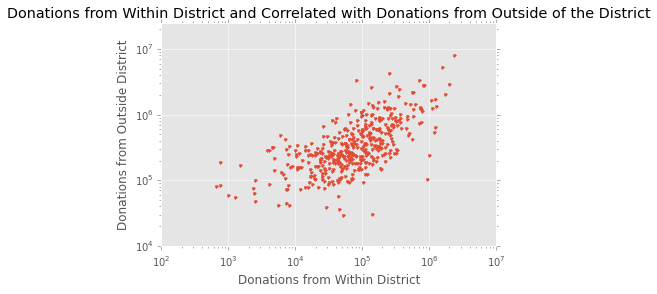

In [6]:
_ = plt.loglog(df_recipient_districts.DonateFromSelf, df_recipient_districts.DonateFromOther, '.')[0]
plt.ylim(10 ** 4, 10 ** 7.4)
plt.title("Donations from Within District and Correlated with Donations from Outside of the District")
plt.xlabel("Donations from Within District")
plt.ylabel("Donations from Outside District")

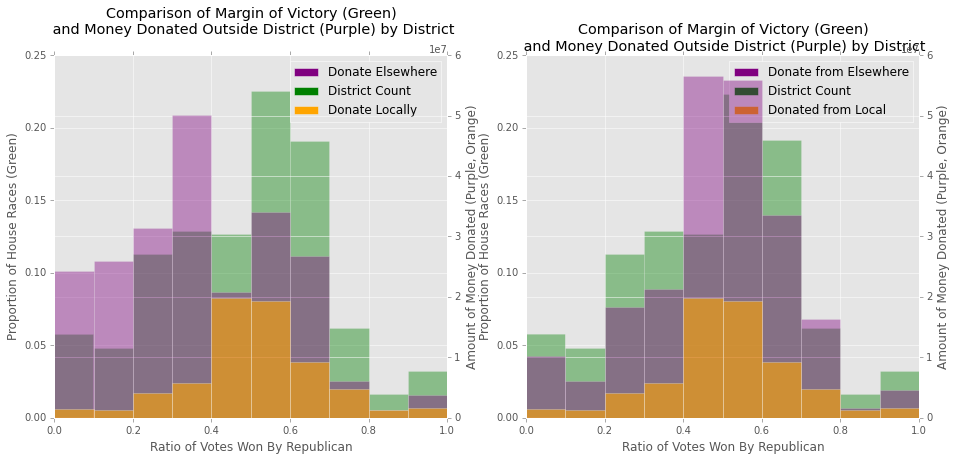

In [41]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15.5, 6.5)

axs[0].hist(df_donor_with_previous.RepublicanRatio * 10, normed=True, alpha=0.4, color='green')
axs2 = axs[0].twinx()
axs2.bar(np.arange(10), df_donor_with_previoushist.DonateToOther, 1, alpha=.4, color='purple')
axs2.bar(np.arange(10), df_donor_with_previoushist.DonateToSelf, 1, alpha=.6, color="orange")
_ = axs[0].set_title('Comparison of Margin of Victory (Green)\n and Money Donated Outside District (Purple) by District\n')
_ = axs[0].set_ylabel("Proportion of House Races (Green)")
_ = axs2.set_ylabel("Amount of Money Donated (Purple, Orange)")
_ = axs[0].set_xlabel("Ratio of Votes Won By Republican")
_ = axs[0].set_xticklabels([.2 * i for i in range(10)])

recs = [mpatches.Rectangle((0,0),1,1,fc='purple'), mpatches.Rectangle((0,0),1,1,fc='green'), mpatches.Rectangle((0,0),1,1,fc='orange')]
_ = axs[0].legend(recs, ('Donate Elsewhere', 'District Count', 'Donate Locally'))

axs[1].hist(df_recipient_with_previous.RepublicanRatio * 10, normed=True, alpha=0.4, color='green')
axs2 = axs[1].twinx()
axs2.bar(np.arange(10), df_recipient_with_previoushist.DonateFromOther, 1, alpha=.4, color='purple')
axs2.bar(np.arange(10), df_recipient_with_previoushist.DonateFromSelf, 1, alpha=.6, color='orange')
_ = axs[1].set_title('Comparison of Margin of Victory (Green)\n and Money Donated Outside District (Purple) by District')
_ = axs[1].set_ylabel("Proportion of House Races (Green)")
_ = axs2.set_ylabel("Amount of Money Donated (Purple, Orange)")
_ = axs[1].set_xlabel("Ratio of Votes Won By Republican")
_ = axs[1].set_xticklabels([.2 * i for i in range(10)])

recs = [mpatches.Rectangle((0,0),1,1,fc='purple'), mpatches.Rectangle((0,0),1,1,fc='green'), mpatches.Rectangle((0,0),1,1,fc='orange')]
_ = axs[1].legend(recs, ('Donate from Elsewhere', 'District Count', 'Donated from Local'))